In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms


In [21]:
dataset = load_dataset("Xenova/quickdraw-small")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0,), (1,))  
])

def preprocess_ops(examples):
    examples['image'] = [preprocess(image) for image in examples['image']]
    return examples

dataset.set_transform(preprocess_ops)

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4500000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
})

In [23]:
n_samples = 100_000
train_dataset, test_dataset, val_dataset = dataset['train'], dataset['test'], dataset['valid']
train_dataset = train_dataset.shard(num_shards=10, index=0)
# test_dataset = test_dataset.shard(num_shards=10, index=0)
# train_dataset = train_dataset.shard(num_shards=10, index=0)
names = train_dataset.features['label'].names
n_classes = len(names)

In [24]:
def id_to_class(idx):
    return names[idx]

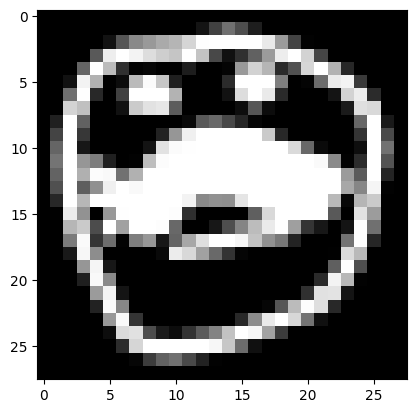

In [25]:

idx = torch.randint(0, 100, (1,))
img, label = test_dataset[idx]['image'], test_dataset[idx]['label']
img = img[0].squeeze(dim=0)
plt.imshow(img, cmap='gray')

## DataLoader

In [26]:
from cnn import CNN

params = {
    'n_filters': 30,
    'hidden_dim': 100,
    'n_layers': 2,
    'n_classes': n_classes
}
model = CNN(**params)
n_params = sum([p.numel() for p in model.parameters()])
print(f'Number of params {n_params}')

Number of params 197385


In [27]:
# hyperparameters
lr = 0.001
batch_size = 128
n_epochs = 5

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

trainLoader, testLoader = DataLoader(train_dataset, batch_size=batch_size), DataLoader(test_dataset, batch_size=batch_size)

In [28]:
def train(model, trainLoader, testLoader, criterion, optimizer, n_epochs):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in tqdm(trainLoader):
            data, labels = batch['image'], batch['label']
            out = model(data)
            preds = out.argmax(dim=1)
            loss = criterion(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (preds == labels).sum().item()

        train_loss /= len(trainLoader)
        train_acc /= len(trainLoader.dataset)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for batch in tqdm(testLoader, disable=True):
                data, labels = batch['image'], batch['label']
                out = model(data)
                loss = criterion(out, labels)
                preds = out.argmax(dim=1)
                test_loss += loss.item()
                test_acc += (preds == labels).sum().item()

        test_loss /= len(testLoader)
        test_acc /= len(testLoader.dataset)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        print(f'epoch {epoch} | train loss {train_loss:.3f} train acc {train_acc:.2f} | test loss {test_loss:.3f} test acc {test_acc:.2f}')
    return train_losses, train_accs, test_losses, test_accs


In [29]:
train_losses, train_accs, test_losses, test_accs = train(model, trainLoader, testLoader, criterion, optimizer, n_epochs)

100%|██████████| 3516/3516 [03:10<00:00, 18.44it/s]


epoch 1 | train loss 3.631 train acc 0.23 | test loss 2.664 test acc 0.40


100%|██████████| 3516/3516 [03:07<00:00, 18.78it/s]


epoch 2 | train loss 2.940 train acc 0.34 | test loss 2.376 test acc 0.46


100%|██████████| 3516/3516 [03:07<00:00, 18.79it/s]


epoch 3 | train loss 2.794 train acc 0.36 | test loss 2.264 test acc 0.48


100%|██████████| 3516/3516 [03:13<00:00, 18.15it/s]


epoch 4 | train loss 2.719 train acc 0.38 | test loss 2.224 test acc 0.49


100%|██████████| 3516/3516 [03:04<00:00, 19.02it/s]


epoch 5 | train loss 2.660 train acc 0.39 | test loss 2.177 test acc 0.50


In [36]:
torch.save(model.state_dict(), 'weights/cnn.pth')